<a href="https://colab.research.google.com/github/NBK-code/Intel_Image_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Necessary Libraries


In [1]:
import pathlib
import cv2
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#Download Intel Dataset

In [2]:
from zipfile import ZipFile
file_name = 'Intel.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


##Construct Train and Test Data

In [3]:
data_dir_train = pathlib.Path('/content/seg_train/seg_train')
data_dir_test = pathlib.Path('/content/seg_test/seg_test')
data_dir_pred = pathlib.Path('/content/seg_pred')

In [4]:
print('The number of train images:', len(list(data_dir_train.glob('*/*.jpg'))))
print('The number of test images:', len(list(data_dir_test.glob('*/*.jpg'))))
print('The number of pred images:', len(list(data_dir_pred.glob('*/*.jpg'))))

The number of train images: 14034
The number of test images: 3000
The number of pred images: 7301


In [5]:
Intel_train_images_dict = {
    'buildings': list(data_dir_train.glob('buildings/*')),
    'forest': list(data_dir_train.glob('forest/*')),
    'glacier': list(data_dir_train.glob('glacier/*')),
    'mountain': list(data_dir_train.glob('mountain/*')),
    'sea': list(data_dir_train.glob('sea/*')),
    'street': list(data_dir_train.glob('street/*'))
}

In [6]:
Intel_train_images_len_dict = {
    'buildings': len(list(data_dir_train.glob('buildings/*'))),
    'forest': len(list(data_dir_train.glob('forest/*'))),
    'glacier': len(list(data_dir_train.glob('glacier/*'))),
    'mountain': len(list(data_dir_train.glob('mountain/*'))),
    'sea': len(list(data_dir_train.glob('sea/*'))),
    'street': len(list(data_dir_train.glob('street/*')))
}

Intel_train_images_len_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

It is a balanced dataset.

In [7]:
Intel_test_images_dict = {
    'buildings': list(data_dir_test.glob('buildings/*')),
    'forest': list(data_dir_test.glob('forest/*')),
    'glacier': list(data_dir_test.glob('glacier/*')),
    'mountain': list(data_dir_test.glob('mountain/*')),
    'sea': list(data_dir_test.glob('sea/*')),
    'street': list(data_dir_test.glob('street/*'))
}

In [8]:
Intel_labels_dict = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [9]:
X_train, y_train = [], []

for category, images in Intel_train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_train.append(resized_img)
        y_train.append(Intel_labels_dict[category])

In [10]:
X_test, y_test = [], []

for category, images in Intel_test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_test.append(resized_img)
        y_test.append(Intel_labels_dict[category])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

In [12]:
X_train_scaled = np.array(X_train) / 255.0
X_val_scaled = np.array(X_val) / 255.0
X_test_scaled = np.array(X_test) / 255.0

In [13]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [14]:
print('Shape of X_train_scaled:', X_train_scaled.shape)
print('Shape of X_val_scaled:', X_val_scaled.shape)
print('Shape of X_test_scaled:', X_test_scaled.shape)

Shape of X_train_scaled: (10525, 128, 128, 3)
Shape of X_val_scaled: (3509, 128, 128, 3)
Shape of X_test_scaled: (3000, 128, 128, 3)


##Build Model

In [15]:
vgg16 = VGG16(input_shape = (128,128,3) , weights='imagenet', include_top=False)

In [16]:
for layer in vgg16.layers:
    layer.trainable = False

In [17]:
h1 = Flatten()(vgg16.output)
h2 = Dense(50, activation = 'relu')(h1)
prediction = Dense(6, activation='softmax')(h2)

model = Model(inputs=vgg16.input, outputs=prediction)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [19]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [20]:
r = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))

Epoch 1/10
329/329 [==============================] - 22s 41ms/step - loss: 0.4473 - accuracy: 0.8383 - val_loss: 0.3791 - val_accuracy: 0.8638
Epoch 2/10
329/329 [==============================] - 12s 37ms/step - loss: 0.2782 - accuracy: 0.8996 - val_loss: 0.3353 - val_accuracy: 0.8817
Epoch 3/10
329/329 [==============================] - 12s 37ms/step - loss: 0.2157 - accuracy: 0.9193 - val_loss: 0.4132 - val_accuracy: 0.8584
Epoch 4/10
329/329 [==============================] - 12s 37ms/step - loss: 0.1684 - accuracy: 0.9381 - val_loss: 0.3478 - val_accuracy: 0.8814
Epoch 5/10
329/329 [==============================] - 12s 37ms/step - loss: 0.1373 - accuracy: 0.9533 - val_loss: 0.3436 - val_accuracy: 0.8903
Epoch 6/10
329/329 [==============================] - 12s 37ms/step - loss: 0.1017 - accuracy: 0.9667 - val_loss: 0.3924 - val_accuracy: 0.8832
Epoch 7/10
329/329 [==============================] - 12s 37ms/step - loss: 0.0879 - accuracy: 0.9699 - val_loss: 0.3986 - val_accuracy:

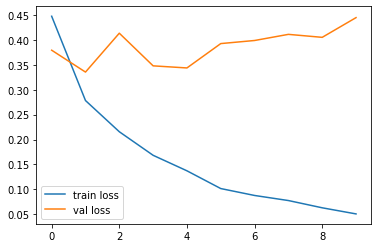

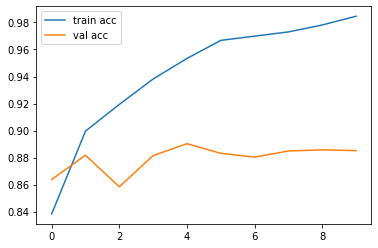

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

##Model Predictions

In [22]:
model.evaluate(X_test_scaled,y_test)

94/94 [==============================] - 3s 31ms/step - loss: 0.4312 - accuracy: 0.8803


[0.43121418356895447, 0.8803333044052124]